In [ ]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import datetime
from scipy import stats
# the code below is inspired by and adapted from the code released with 
# Bayesian Modeing and Computation in Python by Martin, Kuman, Lau copyright 2022,
# https://bayesiancomputationbook.com/welcome.html
# which was released under the VNU General Public license Version 2

Question: What is a range of likely last freeze dates after which it will be safe to plant tomatoes outside?

The last freeze date is the last day of the year prior to July 30 that the overnight low reaches $32\ ^{\circ}\mathrm{F}$. However, frost can form at higher overnight temperatures.  Typically, if the temperature doesn't drop below $36\ ^{\circ}\mathrm{F}$ my tomato plants have been safe. Therefore, my "last frost date" will be the last date when the overnight low is $36\ ^{\circ}\mathrm{F}$ or below.

I obtained weather data from NOAA's online database. The data comes from the MIDLAND, MI US USC00205434 weather station near Midland's water treatment plant. Minimum temperature is labeled TMIN, and I downloaded data from  April 6 1971 to April 5, 2025, although only data through July 2024 is relevant for the calculation, as the last freeze has not happened yet in 2025. 

In [634]:
weather_data = pd.read_csv("MIDLANDMI1971to2025DailyLowT.csv", 
                           sep=",", header=0, index_col=False, parse_dates = ['DATE'])


Add columns with just the year and day of year so we can group by the year, filter by the day of the year, and return the day of the year easily.

In [4]:
weather_data['DAY'] = weather_data['DATE'].apply(lambda x: x.dayofyear)
weather_data['YEAR'] = weather_data['DATE'].apply(lambda x: x.year)
weather_data.head()

,DATE,TMIN,DAY,YEAR
0,1971-04-06,18.0,96,1971
1,1971-04-07,25.0,97,1971
2,1971-04-08,28.0,98,1971
3,1971-04-09,40.0,99,1971
4,1971-04-10,26.0,100,1971


Find the last day of each year before July 30 that had a temperature of 36 or less. On a leap year July 30 is the 212th day since Jan 1 and 211th on a non-leap year.  I am satisfied with the 30th of July for leap years and the 1st of August otherwise. Grouping the data by year lets me sort out the last day of each year with the low temperature.

In [5]:
lastday = 211
min_temp = 36
limited_weather = weather_data.query('TMIN <= @min_temp & DAY <= @lastday & YEAR < 2025')
limited_weather.head()

,DATE,TMIN,DAY,YEAR
0,1971-04-06,18.0,96,1971
1,1971-04-07,25.0,97,1971
2,1971-04-08,28.0,98,1971
4,1971-04-10,26.0,100,1971
8,1971-04-14,28.0,104,1971


In [6]:
grouped_limited_weather = limited_weather.groupby('YEAR')
lastfrost = grouped_limited_weather.last()
lastfrost

,DATE,TMIN,DAY
YEAR,,,
1971,1971-06-10,36.0,161
1972,1972-06-11,32.0,163
1973,1973-05-20,35.0,140
1974,1974-05-08,32.0,128
1975,1975-04-26,31.0,116
1976,1976-05-24,36.0,145
1977,1977-06-07,32.0,158
1978,1978-05-07,34.0,127
1979,1979-05-16,34.0,136


I will model the last day with temperatures below the minimum. 

Lastfrost['DAY'] gives the observed data. It is useful to plot the data to see what its distribution might be.

Text(0, 0.5, 'Number of Instances')

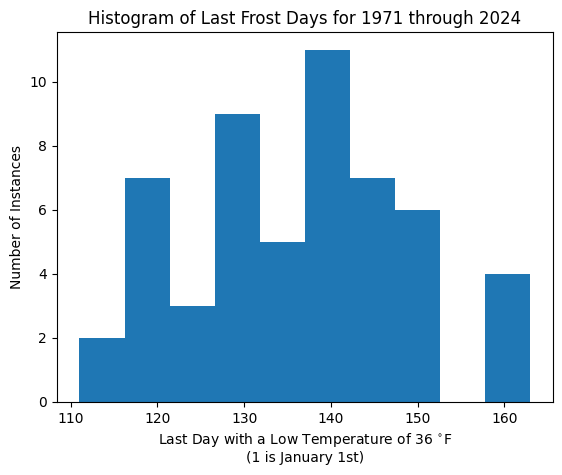

In [ ]:
fig, ax  = plt.subplots()
ax.hist(lastfrost['DAY'])
ax.set_title("Histogram of Last Frost Days for 1971 through 2024")
ax.set_xlabel("Last Day with a Low Temperature of "+r"$36\ ^{\circ}\mathrm{F}$" +"\n(1 is January 1st)")
ax.set_ylabel("Number of Instances")

First note that there are a number of values around 160 that don't fit with the rest of the data. When did these occur?

In [8]:
lastfrost.query('DAY >= 155')

,DATE,TMIN,DAY
YEAR,,,
1971,1971-06-10,36.0,161
1972,1972-06-11,32.0,163
1977,1977-06-07,32.0,158
1980,1980-06-11,36.0,163


Interesting that all four of these values occured before 1981.  Use a time plot to find out if there is any indication that the last frost date has been changing.

Text(0, 0.5, 'Last Day with a Low Temperature of $36\\ ^{\\circ}\\mathrm{F}$')

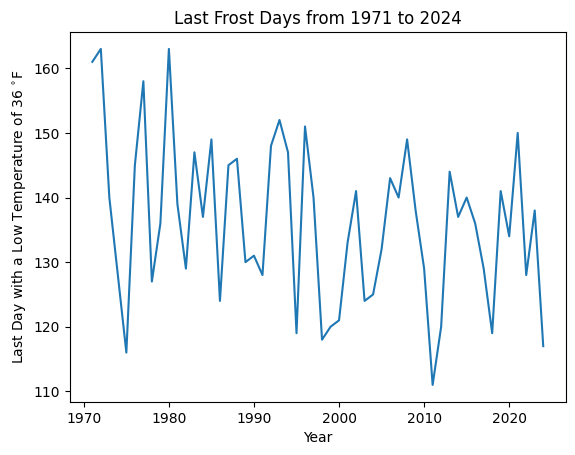

In [256]:
fig, ax = plt.subplots()
ax.plot(lastfrost['DAY'])
ax.set_title("Last Frost Days from 1971 to 2024")
ax.set_xlabel("Year")
ax.set_ylabel("Last Day with a Low Temperature of "+r"$36\ ^{\circ}\mathrm{F}$")

Visually, there seems to be an overall decline in the day of last frost. The variance also appears to be larger for the first few data points, though it can be hard to visusally identify changes in variance. It may be worth comparing models that take these change into account and models that do not.

To create an effective model, I need to select a distribution from which to draw random samples. Normal distributions are common in nature, so a normal distribution may be a good start to the model. The histogram before this time plot could plausibly follow the normal distibution, though it appears to be a bit skewed. The quantile-quantile plot shows a relatively straight line. This suggests that it may be reasonable to use a normal distribution for the model.

Text(0, 0.5, 'Last Day with Tempertautes Below $36\\ ^{\\circ}\\mathrm{F}$')

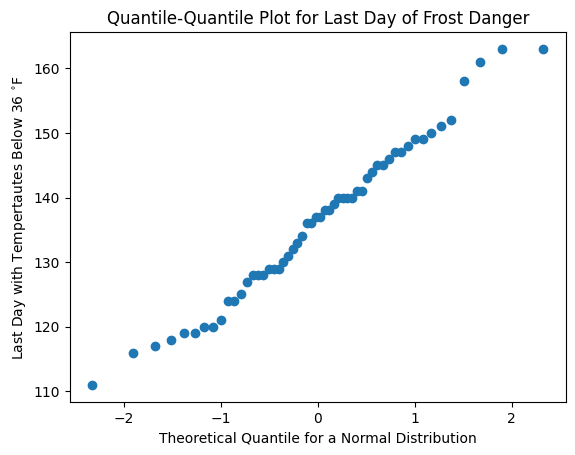

In [ ]:
quantile_percents = np.linspace(.01,.99,num=54)
quantiles = stats.norm.ppf(quantile_percents)
fig, ax = plt.subplots()
ax.scatter(quantiles, lastfrost["DAY"].sort_values())
ax.set_title("Quantile-Quantile Plot")
ax.set_xlabel("Theoretical Quantile for a Normal Distribution")
ax.set_ylabel(r"Last Day with Tempertautes Below $36\ ^{\circ}\mathrm{F}$")

I will consider 3 models, all of which draw data from a normal distribution:
- A model where the only variation comes from the underlying distribution, and there is no effect from the year (Constant)
- A model where the variation comes from the underlying distribution, and the mean of that distribution is changing linearly with the year (Changing Mean)
- A model where the variation comes from the underlying distribution, and both the mean and variance of that distribution change linearly with the year (Changing Mean and SD)

For the Constant model, I need to establish priors for the mean and standard deviation of my distribution based on my knowledge of the weather.  I don't have a good idea of which days are more likely to be the last frost date, except that gardening sites indicate the last frost date will be between May 4 and May 31. Therefore, I will use a uniform distribution including these days for the prior of the mean.  The standard deviation must be positive and is most probably about $\frac{1}{\sqrt{2}}$ times the range of the dates, or about 19. Therefore, I will use a half-normal distribution with a standard deviation of 19 for the prior of its prior. We will ignore the effect of the leap year in the prior, since it should have a relatively small effect that will be unimportant once the prior is compared with observed data.

In [ ]:
#Convert May 4 and 31 to day of year
earliest_likely = datetime.date(year=2025, month=5, day=4).timetuple().tm_yday
latest_likely = datetime.date(year=2025, month=5, day=31).timetuple().tm_yday

151

In [266]:

# Declare a model
with pm.Model() as constant:
    # Specify the prior distribution of unknown parameter
    mu = pm.DiscreteUniform("mu",lower=earliest_likely, upper=latest_likely)
    sigma = pm.HalfNormal("sigma", sigma=19)
  
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=lastfrost["DAY"])
    #draw 1000 posterior samples
    idata_const = pm.sample(return_inferencedata=True)
    idata_const.add_groups({"posterior_predictive": {"Y_obs":pm.sample_posterior_predictive(idata_const)["Y_obs"][None,:]}})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
# view model diagnostics
summary_constant = az.summary(idata_const, kind="diagnostics", round_to=3)
summary_constant

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.058,0.041,924.420,966.715,1.005
sigma,0.033,0.023,1539.176,2296.033,1.000


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

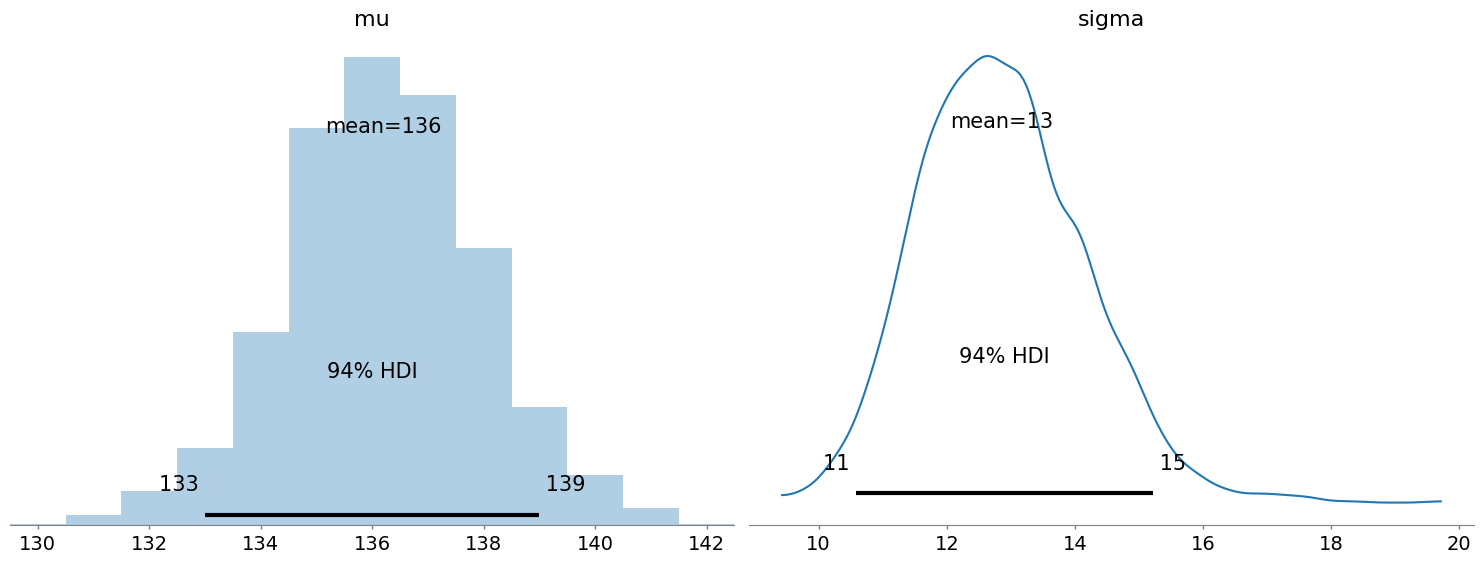

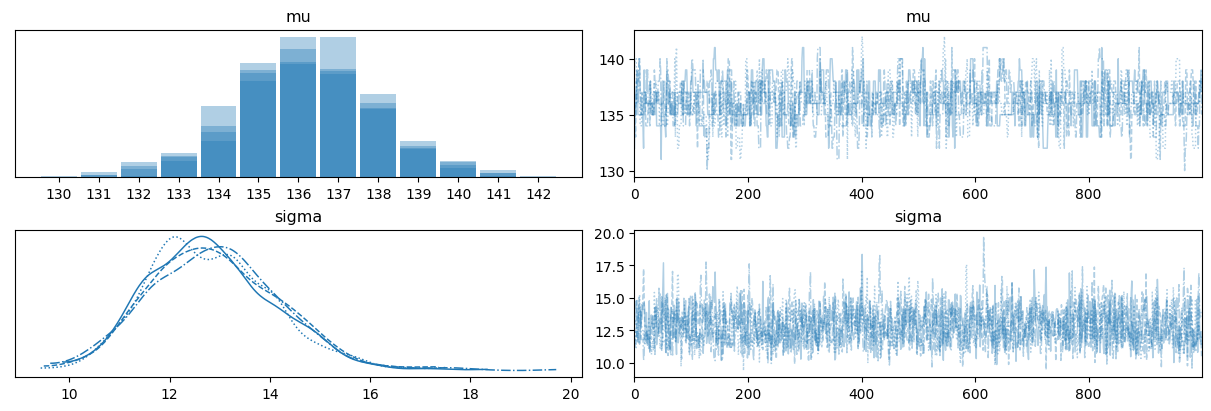

In [ ]:
# check model output
# posterior distributions
az.plot_posterior(idata_const)

# individual traces
az.plot_trace(idata_const)

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

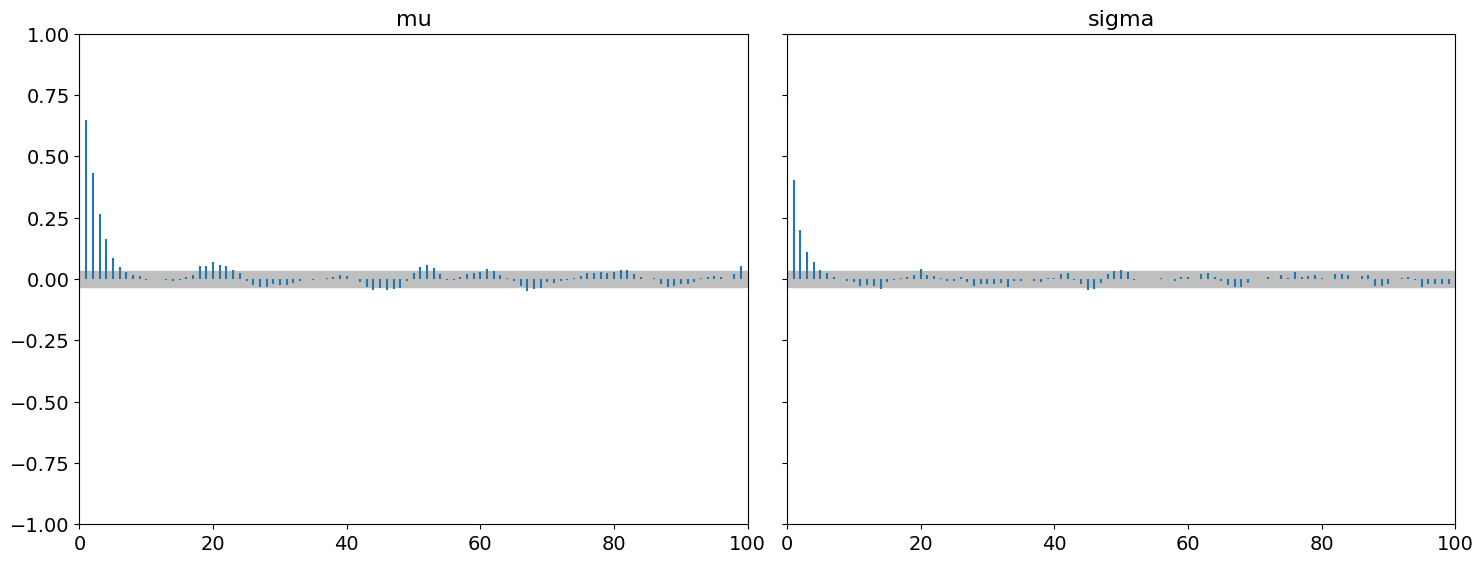

In [370]:
# view autocorrelation
az.plot_autocorr(idata_const, combined=True)

array([<AxesSubplot:title={'center':'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

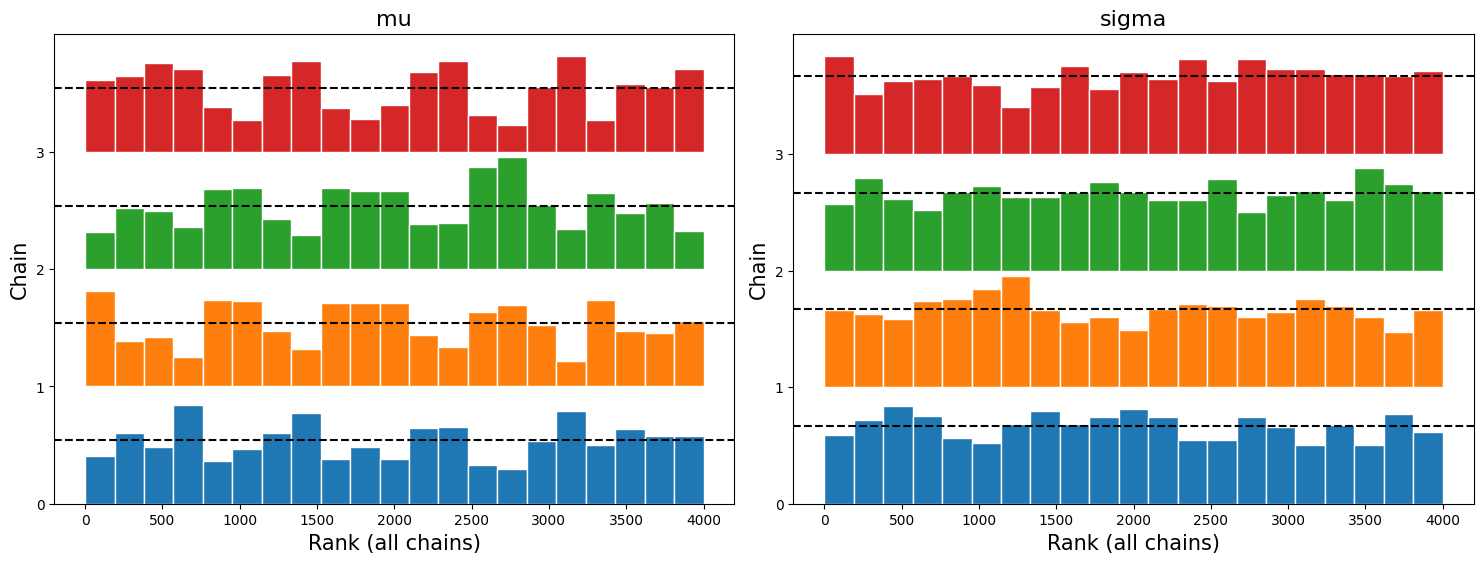

In [371]:
# view chain distributions
az.plot_rank(idata_const)

For the Changing Mean model, I need to use a linear relationship for the mean: $\mu = \beta_0 + \beta_1*x$ where $x$ is the years since 1971. The coefficients $\beta_0$ and $\beta_1$ must be drawn from statistical distributions. Based on the graph, it's clear that the intercept must be somewhere between the earliest and latest last frost dates, so we are reasonable in choosing a uniform distribution between those dates for the prior of $\beta_0$. The slope is likely close to zero, so we can choose a normal distribution with a mean of 0 and a wide variance so that we do not have too much influence on the model's outcome for slope.  We want to avoid influence because we have poor knowlege of what the slope might be. The slope must be less than one day per year, or we would be seeing last frost dates in April, so a standard deviation of 6 is broad compared to this limit. It makes sense to use the same prior for the standard deviation since it does not change in this model.

In [281]:
with pm.Model() as changing_mean:
    year = pm.Data("Year",lastfrost["DAY"].index.values-lastfrost["DAY"].index.values[0])
    sigma = pm.HalfNormal("sigma", sigma=19)
    beta0 = pm.Uniform("beta0", lower=116, upper=163)
    beta1 = pm.Normal("beta1", 0, 6) 
    mu = pm.Deterministic("mu", beta0 + beta1 * year)

    # Likelihood of observations
    Y_obs = pm.Gamma("Y_obs", mu=mu, sigma=sigma, observed=lastfrost["DAY"])
    #draw 1000 posterior samples
    idata_changing_mean = pm.sample(return_inferencedata=True)
    idata_changing_mean.add_groups({"posterior_predictive": {"Y_obs":pm.sample_posterior_predictive(idata_changing_mean)["Y_obs"][None,:]}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [522]:
#view model diagnostics
summary_changing_mean_betas = az.summary(idata_changing_mean, var_names=['beta0','beta1'], round_to=3)
summary_changing_mean_mu_avg = pd.DataFrame(data=az.summary(idata_changing_mean,var_names=['mu'], round_to=3).mean(axis=0),columns=['mu(mean)']).transpose()
summary_changing_mean_mu_min = pd.DataFrame(data=az.summary(idata_changing_mean,var_names=['mu'], round_to=3).min(axis=0),columns=['mu(min)']).transpose()
summary_changing_mean_mu_max = pd.DataFrame(data=az.summary(idata_changing_mean,var_names=['mu'], round_to=3).max(axis=0),columns=['mu(max)']).transpose()
summary_changing_mean_sigma = az.summary(idata_changing_mean, var_names=['sigma'],round_to=3)
summary_changing_mean = pd.concat([summary_changing_mean_betas, summary_changing_mean_mu_min, summary_changing_mean_mu_avg, summary_changing_mean_mu_max, summary_changing_mean_sigma])
summary_changing_mean

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,142.398000,3.445000,135.585000,148.278000,0.082000,0.058000,1784.607000,1741.493000,1.004000
beta1,-0.232000,0.112000,-0.443000,-0.024000,0.003000,0.002000,1853.402000,1976.724000,1.003000
mu(min),130.114000,1.653000,123.856000,136.277000,0.026000,0.018000,1784.607000,1702.433000,1.000000
mu(mean),136.255796,2.343852,131.852611,140.520519,0.045944,0.032556,2915.721019,2606.716889,1.001667
mu(max),142.398000,3.445000,135.753000,148.278000,0.082000,0.058000,4288.820000,3243.500000,1.004000
sigma,12.400000,1.280000,10.037000,14.800000,0.030000,0.021000,1764.055000,1644.042000,1.003000


array([[<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

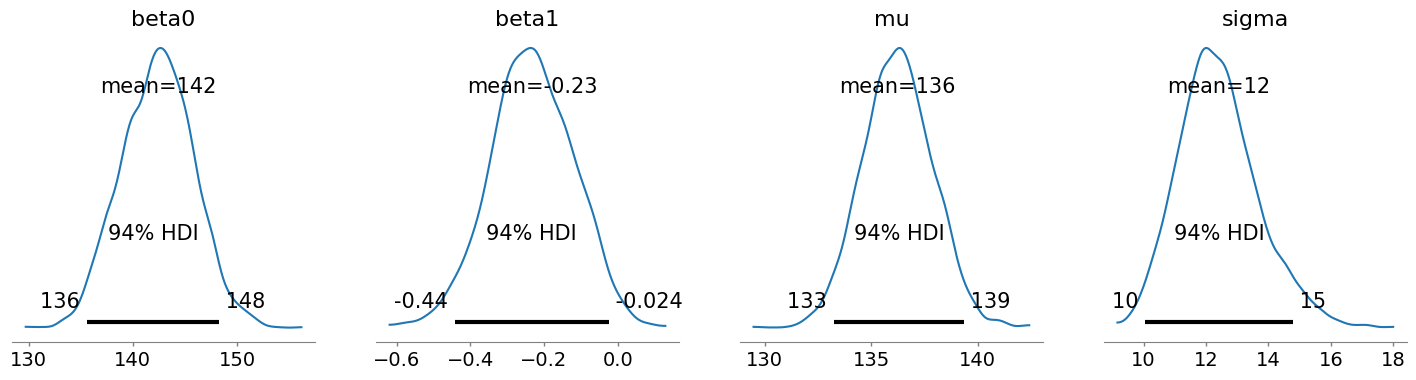

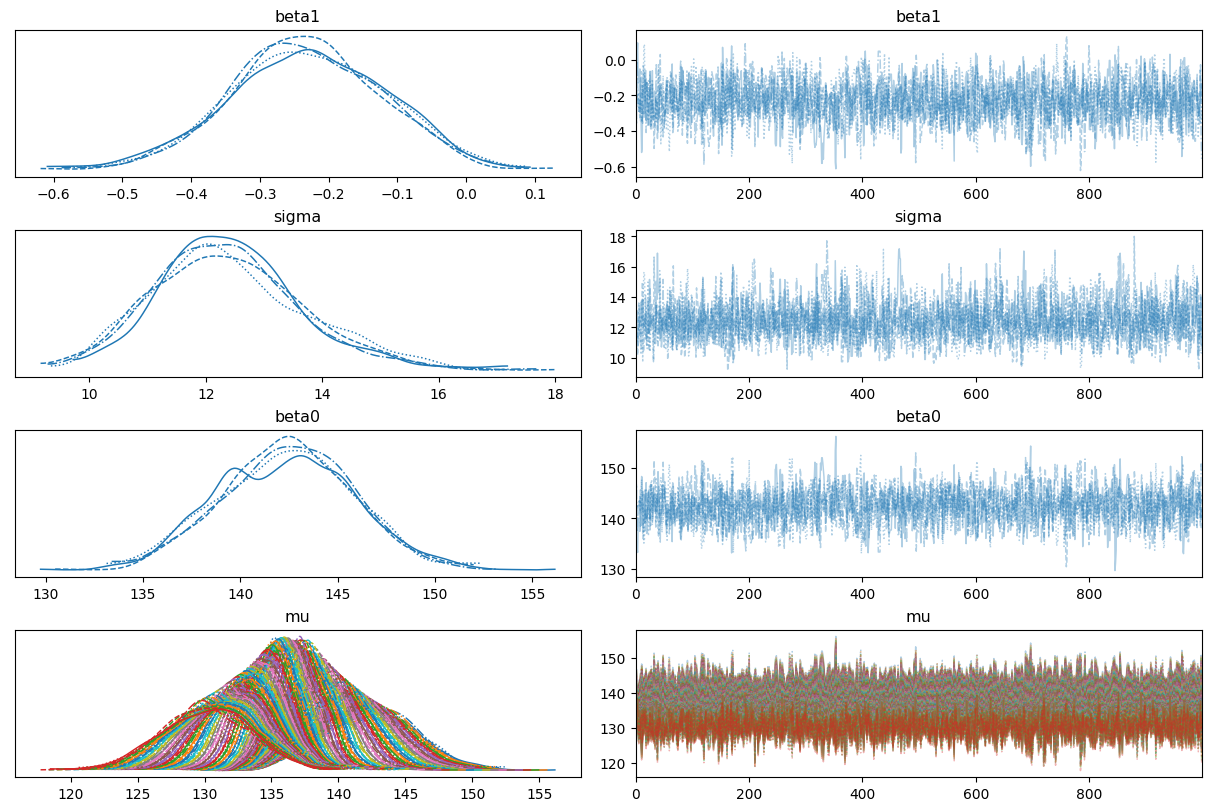

In [ ]:
# view model output
# posterior distributions (mean for mu)
fig, axs = plt.subplots(1,4, figsize=(18,4))
az.plot_posterior(idata_changing_mean, var_names=['beta0','beta1','sigma'],ax=[axs[0],axs[1],axs[3]])
az.plot_posterior(idata_changing_mean["posterior"]["mu"].mean(axis=2),ax=axs[2])

# individual traces
az.plot_trace(idata_changing_mean)

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

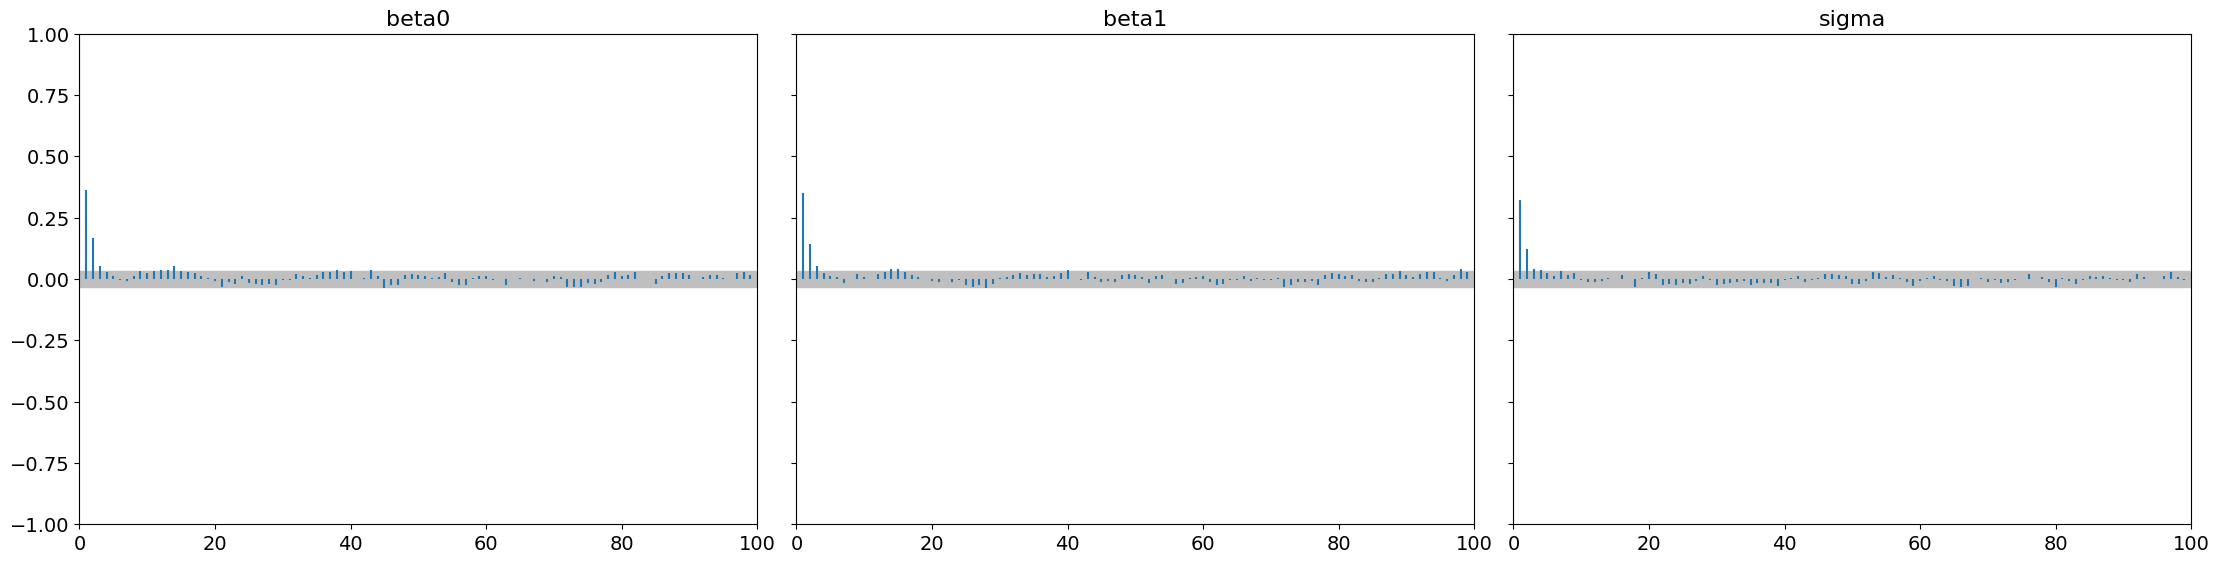

In [375]:
# view autocorrelation
az.plot_autocorr(idata_changing_mean, var_names=['beta0','beta1','sigma'], combined=True)

array([<AxesSubplot:title={'center':'beta0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'beta1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

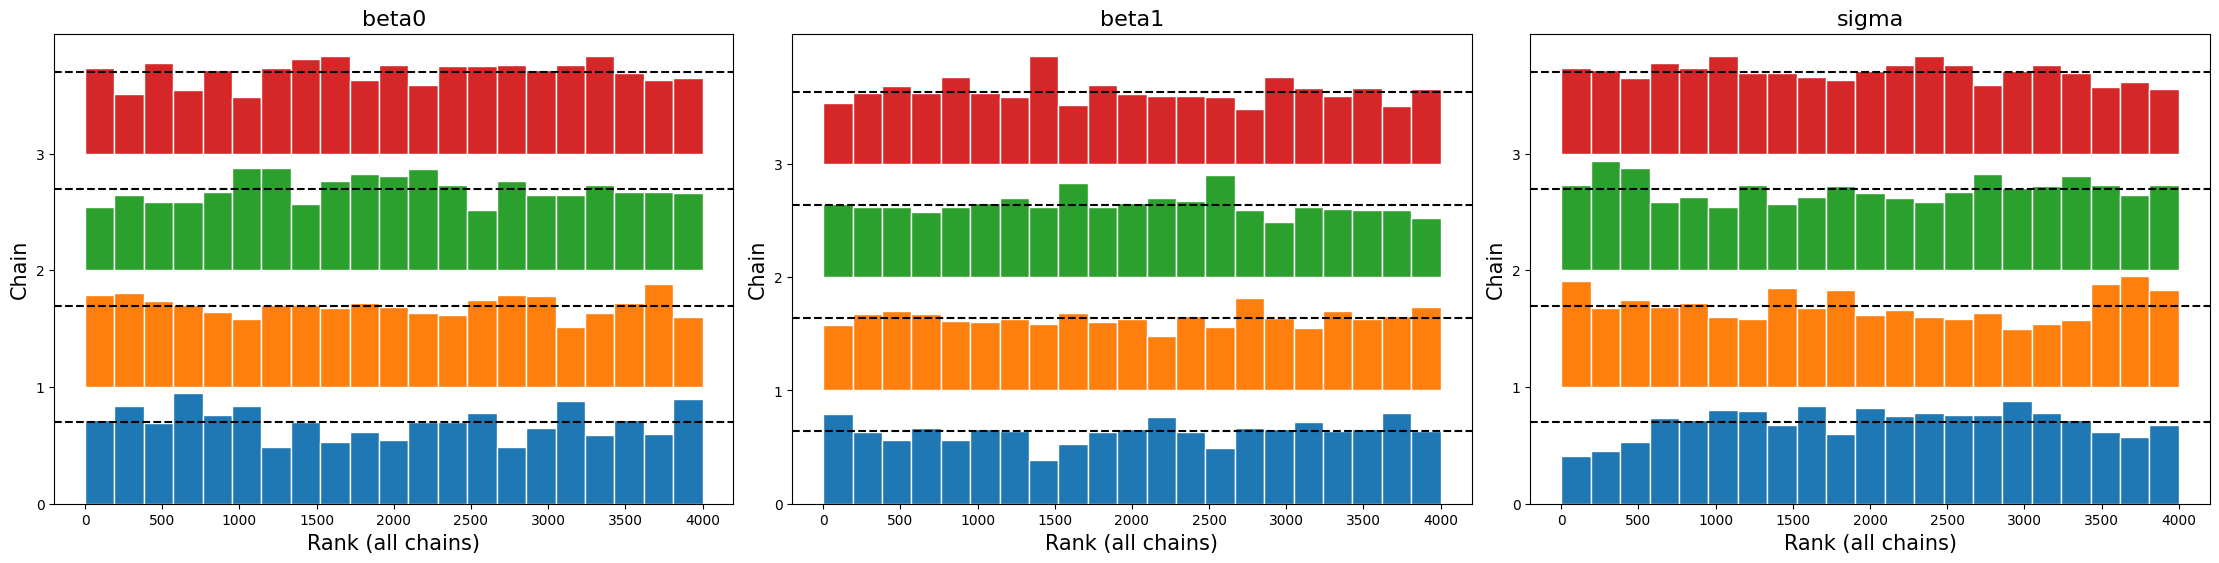

In [378]:
# view chain distribution
az.plot_rank(idata_changing_mean,var_names=['beta0', 'beta1','sigma'])

For the Changing Mean and SD model, I need to use a linear relationship for the mean and the standard deviation: $\mu = \beta_0 + \beta_1*x$ and $\sigma = \beta_2 + \beta_3*x$ where $x$ is the years since 1971. The coefficients $\beta_2$ and $\beta_3$, in addition to $\beta_0$ and $\beta_1$, must be drawn from statistical distributions. The priors for $\beta_0$ and $\beta_1$ are the same as in the previous model.  Using the graph, it's clear that the intercept for the standard deviation must be somewhere between the smallest and largest variations in year-to-year data, so we are reasonable in choosing a uniform distribution between those differences for  $\beta_2$. The variance has not more than doubled or halved during the 54 years of data, so $\beta_2$ must be betweem - 1/54 and + 1/54. A prior with a mean of 0 and a standard deviation of 0.1 is broad compared to this limit, ensuring the outcome is not overly constrained by the priors. 

In [283]:
with pm.Model() as changing_mean_sd:
    year = pm.Data("Year",lastfrost["DAY"].index.values-lastfrost["DAY"].index.values[0])
    beta0 = pm.Uniform("beta0", lower=116, upper=163)
    beta1 = pm.Normal("beta1", 0, 6)
    beta2 = pm.Uniform("beta2",5,63)
    beta3 = pm.Normal("beta3",0,.10)
    mu = pm.Deterministic("mu", beta0 + beta1 * year)
    sigma = pm.Deterministic("sigma", beta2 + beta3 * year)

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=lastfrost["DAY"])
    #draw 1000 posterior samples
    idata_changing_mean_sd = pm.sample(return_inferencedata=True)
    idata_changing_mean_sd.add_groups({"posterior_predictive": {"Y_obs":pm.sample_posterior_predictive(idata_changing_mean_sd)["Y_obs"][None,:]}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [521]:
#view model diagnostics
summary_changing_mean_sd_betas = az.summary(idata_changing_mean_sd, var_names=['beta0','beta1','beta2','beta3'],kind="diagnostics", round_to=3)
summary_changing_mean_sd_mu_avg = pd.DataFrame(data=az.summary(idata_changing_mean_sd,var_names=['mu'], kind="diagnostics", round_to=3).mean(axis=0),columns=['mu(mean)']).transpose()
summary_changing_mean_sd_mu_min = pd.DataFrame(data=az.summary(idata_changing_mean_sd,var_names=['mu'], kind="diagnostics", round_to=3).min(axis=0),columns=['mu(min)']).transpose()
summary_changing_mean_sd_mu_max = pd.DataFrame(data=az.summary(idata_changing_mean_sd,var_names=['mu'], kind="diagnostics", round_to=3).max(axis=0),columns=['mu(max)']).transpose()
summary_changing_mean_sd_sigma_avg = pd.DataFrame(data=az.summary(idata_changing_mean_sd, var_names=['sigma'], kind="diagnostics",round_to=3).mean(axis=0),columns=["sigma(mean)"]).transpose()
summary_changing_mean_sd_sigma_min = pd.DataFrame(data=az.summary(idata_changing_mean_sd, var_names=['sigma'], kind="diagnostics",round_to=3).min(axis=0),columns=["sigma(min)"]).transpose()
summary_changing_mean_sd_sigma_max = pd.DataFrame(data=az.summary(idata_changing_mean_sd, var_names=['sigma'], kind="diagnostics",round_to=3).max(axis=0),columns=["sigma(max)"]).transpose()
summary_changing_mean_sd = pd.concat([summary_changing_mean_sd_betas, summary_changing_mean_sd_mu_min, summary_changing_mean_sd_mu_avg,  summary_changing_mean_sd_mu_max, summary_changing_mean_sd_sigma_min, summary_changing_mean_sd_sigma_avg, summary_changing_mean_sd_sigma_max])
summary_changing_mean_sd

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.100000,0.071000,1269.940000,1648.851000,1.002000
beta1,0.003000,0.002000,1339.167000,1513.960000,1.003000
beta2,0.052000,0.037000,1584.100000,1634.879000,1.005000
beta3,0.001000,0.001000,1567.405000,1424.423000,1.006000
mu(min),0.026000,0.019000,1269.940000,1580.251000,1.000000
mu(mean),0.051444,0.036407,2515.009500,2385.326889,1.001481
mu(max),0.100000,0.071000,4332.370000,3185.820000,1.003000
sigma(min),0.021000,0.015000,1584.100000,1621.951000,1.000000
sigma(mean),0.031111,0.022130,2692.016685,2405.447926,1.001630
sigma(max),0.052000,0.037000,3934.100000,2795.084000,1.005000


array([[<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta3'}>,
        <AxesSubplot:title={'center':'beta3'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

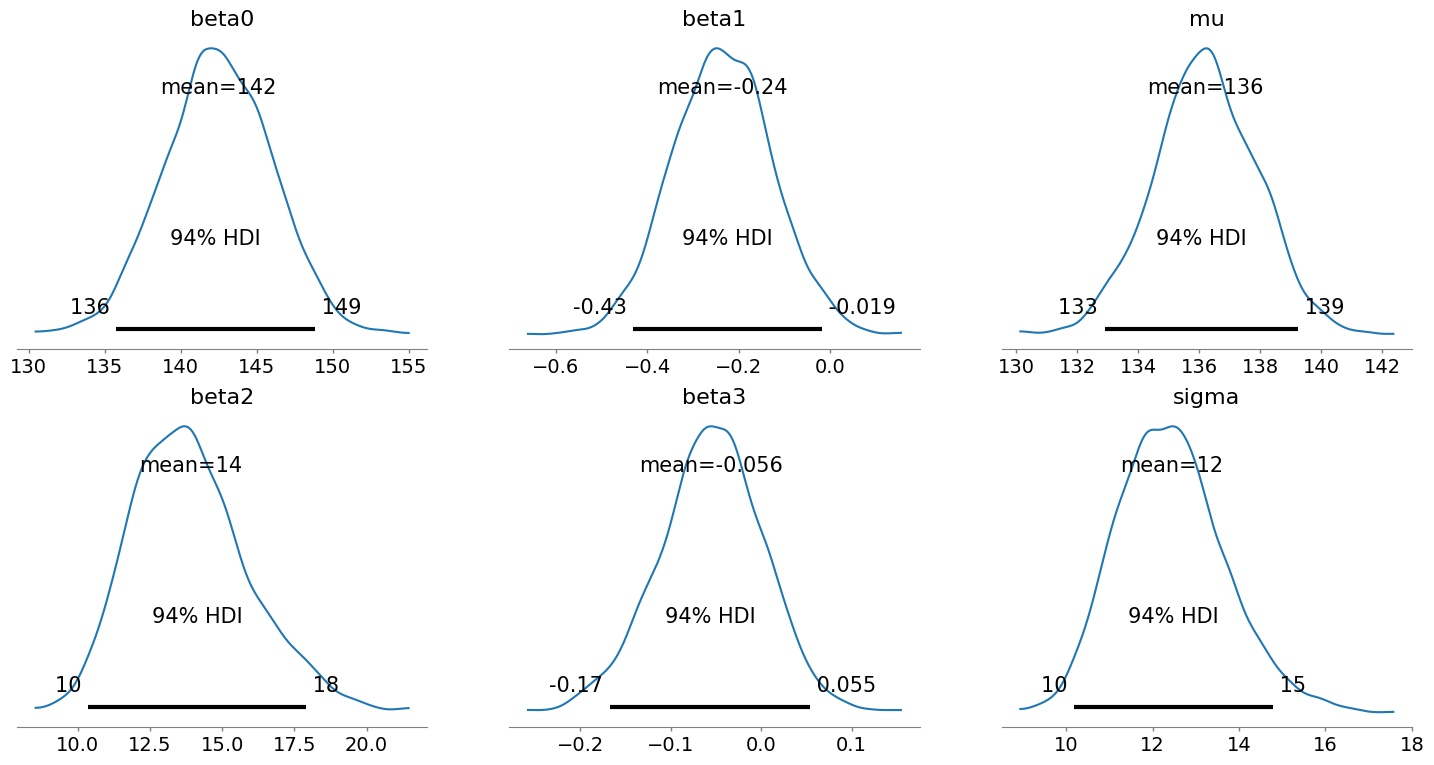

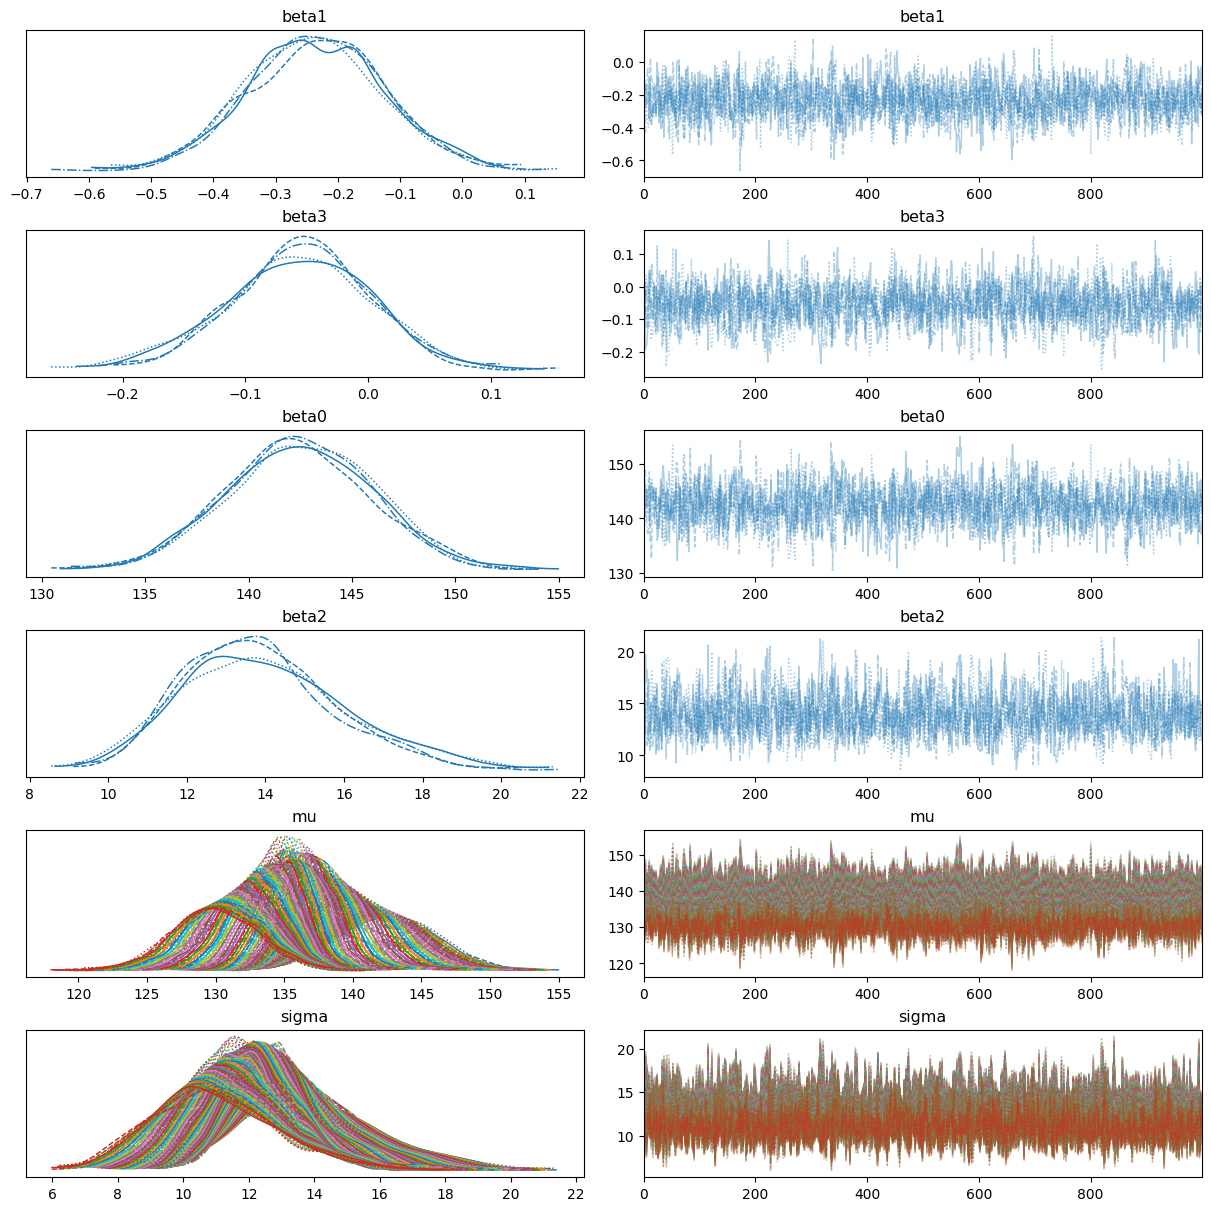

In [445]:
# view model output
# posterior distributions (mean for mu)
fig, axs = plt.subplots(2,3, figsize=(18,9))
az.plot_posterior(idata_changing_mean_sd, var_names=['beta0','beta1','beta2','beta3'],ax=[axs[0,0],axs[0,1],axs[1,0],axs[1,1]])
az.plot_posterior(idata_changing_mean_sd["posterior"]["mu"].mean(axis=2),ax=axs[0,2])
az.plot_posterior(idata_changing_mean_sd["posterior"]["sigma"].mean(axis=2),ax=axs[1,2])

# individual traces
az.plot_trace(idata_changing_mean_sd)

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>,
       <AxesSubplot:title={'center':'beta2'}>,
       <AxesSubplot:title={'center':'beta3'}>], dtype=object)

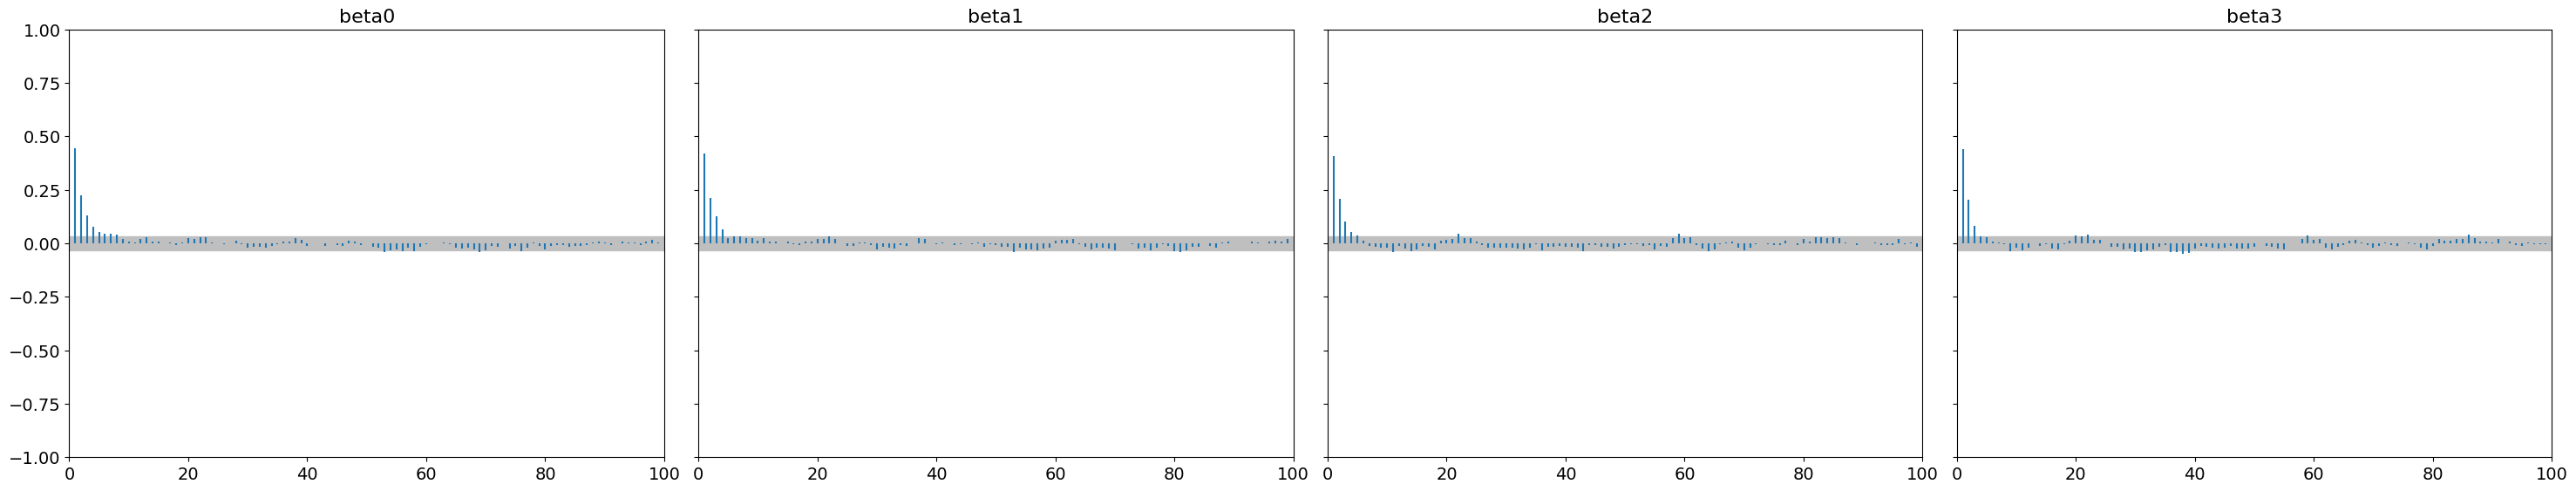

In [379]:
# view autocorrelation
az.plot_autocorr(idata_changing_mean_sd, var_names=['beta0','beta1','beta2','beta3'],combined=True)

array([<AxesSubplot:title={'center':'beta0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'beta1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'beta2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'beta3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

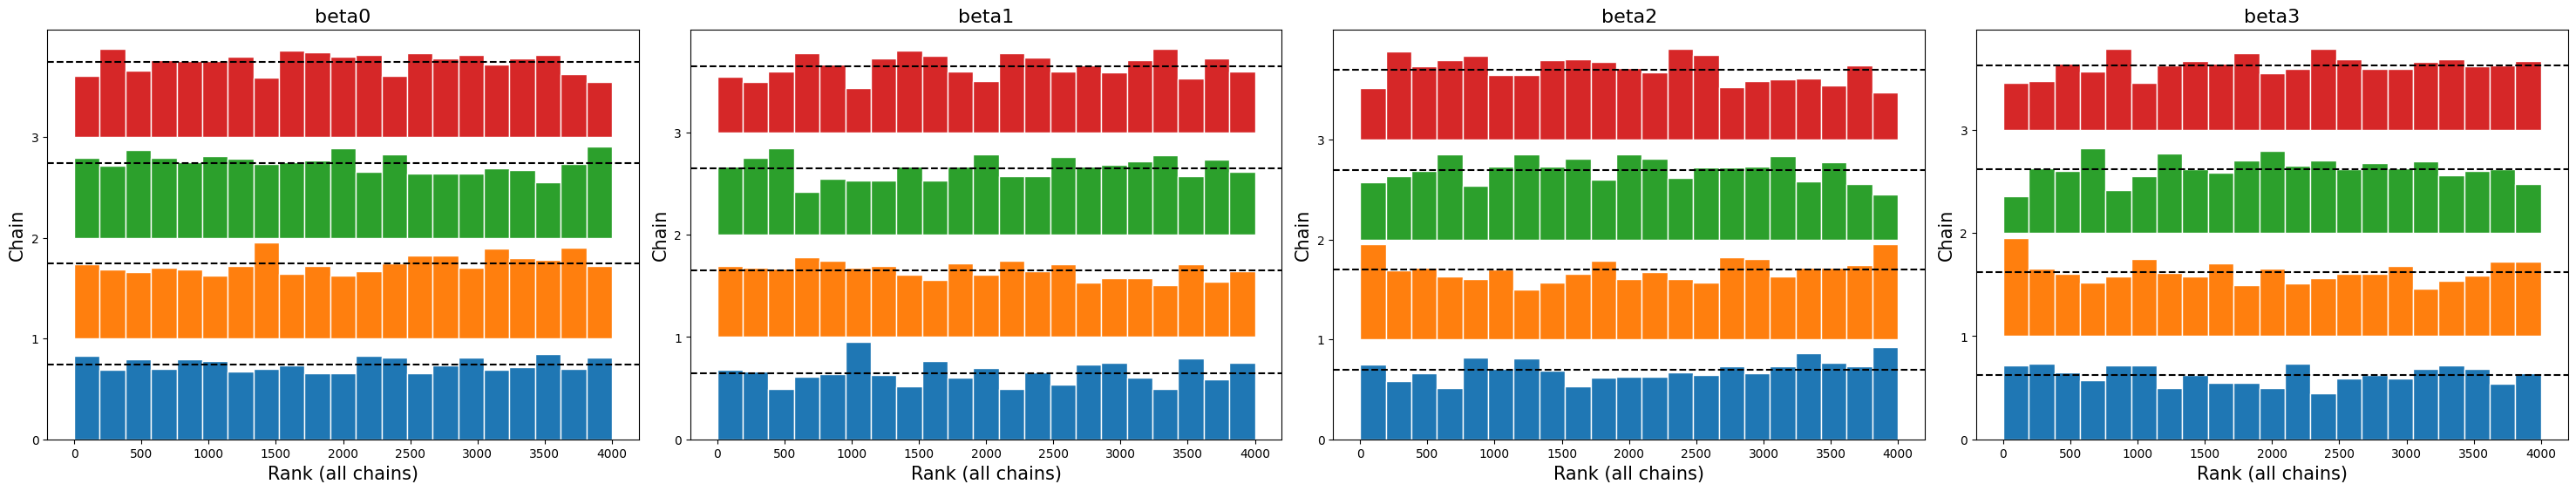

In [380]:
az.plot_rank(idata_changing_mean_sd, var_names=['beta0','beta1','beta2','beta3'])

Having reviewed all three models and output, there is only one significant concern about whether models calculations were effective.  For the Constant model, there is a significant reduction in effective sample size, or ESS, (from 4000 to below 1000) for the mean day of last frost. This is a sign of some autocorrelation in the sample chains, which is evident in all the models. However, the ESS is well above the value of 400 where the estimation of quantities tends to become unstable, so this reduction in sample size does not necessarily mean the constant model must be discarded. Furthermore, all models resulted in very similar estimates of the mean values for mu and sigma, the mean and standard deviation of the normal distribution representing the last frost date.

A comparison of the fit for the mean last frost date and the the data for all three models is below:

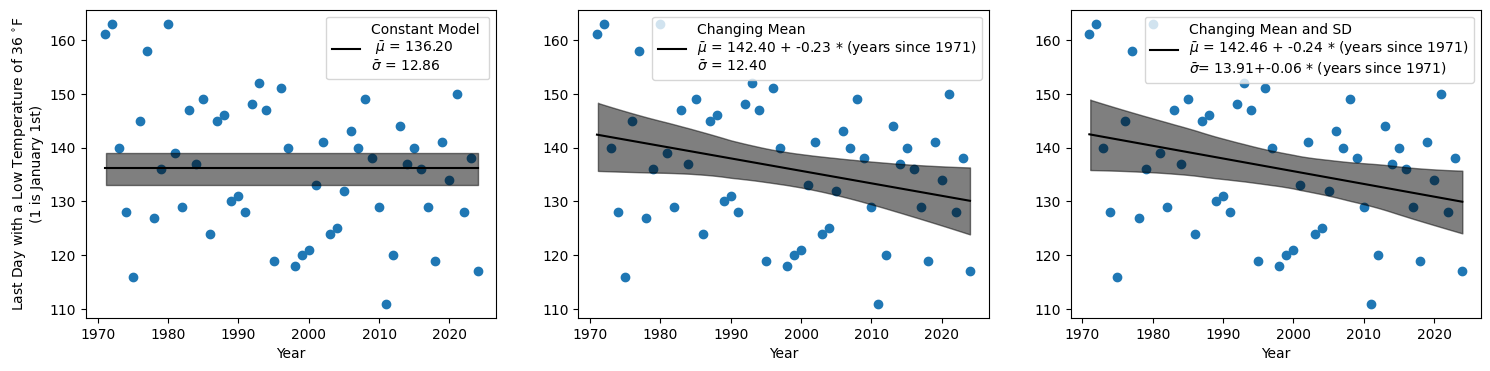

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))
mean_const = idata_const.posterior.mean().to_dict()["data_vars"]["mu"]["data"]
sigma_const = idata_const.posterior.mean().to_dict()["data_vars"]["sigma"]["data"] 
beta0_changing_m = idata_changing_mean.posterior.mean().to_dict()["data_vars"]["beta0"]["data"]
beta1_changing_m = idata_changing_mean.posterior.mean().to_dict()["data_vars"]["beta1"]["data"]
sigma_changing_m = idata_changing_mean.posterior.mean().to_dict()["data_vars"]["sigma"]["data"]
beta0_changing_m_sd = idata_changing_mean_sd.posterior.mean().to_dict()["data_vars"]["beta0"]["data"]
beta1_changing_m_sd = idata_changing_mean_sd.posterior.mean().to_dict()["data_vars"]["beta1"]["data"]
beta2_changing_m_sd = idata_changing_mean_sd.posterior.mean().to_dict()["data_vars"]["beta2"]["data"]
beta3_changing_m_sd = idata_changing_mean_sd.posterior.mean().to_dict()["data_vars"]["beta3"]["data"]

year = lastfrost["DAY"].index.values

last_frost_constant = np.full(shape=len(lastfrost["DAY"]),fill_value=mean_const)
last_frost_const_hdi = az.hdi(idata_const["posterior"]["mu"])["mu"].values
last_frost_const_hdi_lower = np.full(shape=(len(lastfrost["DAY"])),fill_value=last_frost_const_hdi[0])
last_frost_const_hdi_upper = np.full(shape=(len(lastfrost["DAY"])),fill_value=last_frost_const_hdi[1])
last_frost_const_hdi_array = np.stack((last_frost_const_hdi_lower,last_frost_const_hdi_upper), axis=1)

ax[0].plot(year, last_frost_constant, color='black',
        label=f'Constant Model \n '+r'$\bar{\mu}$'+f' = {mean_const:.2f} \n'+r'$\bar{\sigma}$'+f' = {sigma_const:.2f}')
ax[0].scatter(year, lastfrost["DAY"])
az.plot_hdi(year, hdi_data=last_frost_const_hdi_array, hdi_prob=0.94, color='k', ax=ax[0])
ax[0].sharey(ax[1])

last_frost_changing_m = beta0_changing_m + beta1_changing_m * (year-year[0])
ax[1].plot(year, last_frost_changing_m, color='black',
        label=f'Changing Mean \n'+r'$\bar{\mu}$ '+ f'= {beta0_changing_m:.2f} + {beta1_changing_m:.2f} * (years since {year[0]})\n'+ 
        r'$\bar{\sigma}$ ' + f'= {sigma_changing_m:.2f}')

ax[1].scatter(year, lastfrost["DAY"])

az.plot_hdi(year, idata_changing_mean.posterior['mu'], hdi_prob=0.94, color='k', ax=ax[1])

last_frost_changing_m_sd = beta0_changing_m_sd + beta1_changing_m_sd * (year-year[0])
ax[1].sharey(ax[2])
ax[2].plot(year, last_frost_changing_m_sd, color='black',
        label=f'Changing Mean and SD \n' + r'$\bar{\mu}$'+f' = {beta0_changing_m_sd:.2f} + {beta1_changing_m_sd:.2f} * (years since {year[0]})\n'
        + r'$\bar{\sigma}$' + f'= {beta2_changing_m_sd:.2f}+{beta3_changing_m_sd:.2f} * (years since {year[0]})')

ax[2].scatter(year, lastfrost["DAY"])

az.plot_hdi(year, idata_changing_mean_sd.posterior['mu'], hdi_prob=0.94, color='k', ax=ax[2])


ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[2].set_xlabel('Year')
ax[0].set_ylabel("Last Day with a Low Temperature of "+r"$36\ ^{\circ}\mathrm{F}$" +"\n(1 is January 1st)")
ax[0].legend()
ax[1].legend()
ax[2].legend()

While all three models above seem plausible, the models with changing meen seem to fit the data better. The "leave one out" validation technique or "loo" statistic shown below indicates that each data point in the sample is best predicted by the model (and the other data points) when the variance is allowed to change with time.  However, the highest density interval containing 94% of the probability density for the slope of the changing standard deviation includes 0, so this model is consistent with an unchanging standard deviaiton, too.  The improvement in the model statistics may be from over-fitting rather than a meaningful improvement.

It's worth looking at the predicted last frost day for this year to see if that can differentiate the models.

Text(0.5, 1.0, 'Predicted Last frost date \n Changing Mean and SD')

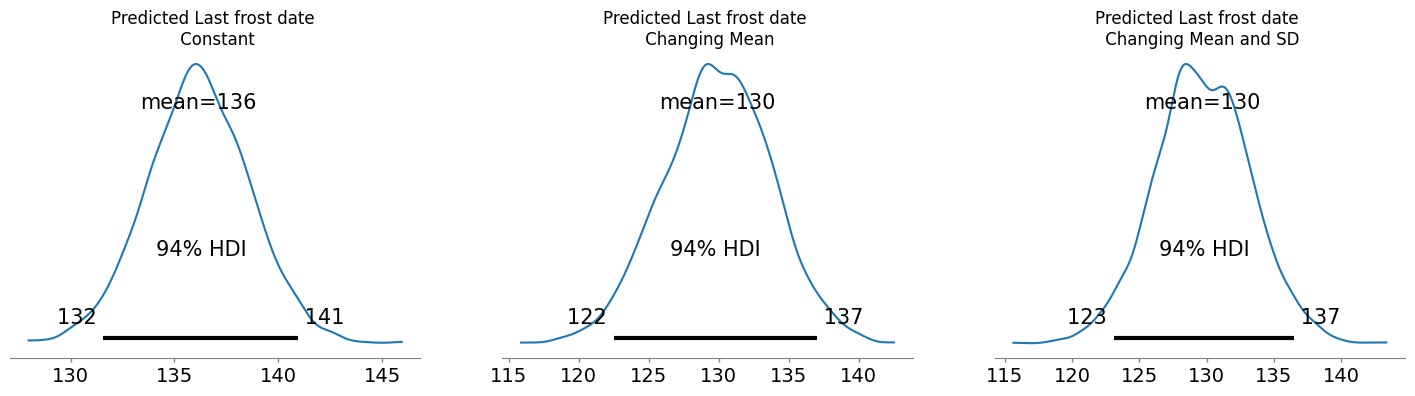

In [ ]:
thisyear = 2025 - lastfrost.index[0]
# predict last frost date for this year
with constant:
    #no year for this model
    posterior_predictions_const = pm.sample_posterior_predictive(idata_const.posterior, var_names=["Y_obs","mu","sigma"])

with changing_mean:
    pm.set_data({"Year": [thisyear]})
    posterior_predictions_changing_mean = pm.sample_posterior_predictive(idata_changing_mean.posterior, var_names=["Y_obs","mu","sigma"])

with changing_mean_sd:
    pm.set_data({"Year": [thisyear]})
    posterior_predictions_changing_mean_sd = pm.sample_posterior_predictive(idata_changing_mean_sd.posterior, var_names=["Y_obs","mu","sigma"])  

fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0] = az.plot_posterior(posterior_predictions_const["Y_obs"].mean(axis=1), ax=ax[0])
ax[0].set_title("Predicted Last frost date \n Constant")
ax[1] = az.plot_posterior(posterior_predictions_changing_mean["Y_obs"].mean(axis=1), ax=ax[1])
ax[1].set_title("Predicted Last frost date \n Changing Mean")
ax[2] = az.plot_posterior(posterior_predictions_changing_mean_sd["Y_obs"].mean(axis=1), ax=ax[2])
ax[2].set_title("Predicted Last frost date \n Changing Mean and SD")

In [631]:
end_of_2024 = datetime.date(2024,12,31).toordinal()
average_last_day_constant = datetime.date.fromordinal(136+end_of_2024)
lowest_in_HDI_constant = datetime.date.fromordinal(132+end_of_2024)
highest_in_HDI_constant = datetime.date.fromordinal(141+end_of_2024)

average_last_day_changing_mean = datetime.date.fromordinal(130+end_of_2024)
lowest_in_HDI_changing_mean = datetime.date.fromordinal(122+end_of_2024)
highest_in_HDI_changing_mean = datetime.date.fromordinal(137+end_of_2024)

average_last_day_changing_mean_sd = datetime.date.fromordinal(130+end_of_2024)
lowest_in_HDI_changing_mean_sd = datetime.date.fromordinal(123+end_of_2024)
highest_in_HDI_changing_mean_sd = datetime.date.fromordinal(137+end_of_2024)
prediction_table = pd.DataFrame({"Constant Model": [average_last_day_constant, lowest_in_HDI_constant, highest_in_HDI_constant], 
                                 "Changing Mean": [average_last_day_changing_mean, lowest_in_HDI_changing_mean, highest_in_HDI_changing_mean],
                                 "Changing Mean and SD": [average_last_day_changing_mean_sd, lowest_in_HDI_changing_mean_sd, highest_in_HDI_changing_mean_sd]},
                                 index=["mean", "3% HDI", "97% HDI"])
prediction_table

,Constant Model,Changing Mean,Changing Mean and SD
mean,2025-05-16,2025-05-10,2025-05-10
3% HDI,2025-05-12,2025-05-02,2025-05-03
97% HDI,2025-05-21,2025-05-17,2025-05-17


There is not enough differentiation in last freeze date to use it to select one model over another since there is significant overlap.  Perhaps comparing model statistics could be helpful. The "leave-one-out" validation technique compares the prediction for a single point to its actual value when predicted using model parameters estimated with all other data. This is then estimated across all points.  The highest value for loo (closest to 0) is preferred. The comparison of "loo" values and Monte Carlo standard error indicate that the model with changing mean and SD best predicts each observation.  However, there is only a slight improvement between the two models with changing means.  There is a slightly larger improvement compared to the model that is constant in time.

In [384]:
# compare model statistics
models = {"Constant": idata_const, "Changing Mean": idata_changing_mean, "Changing Mean and SD": idata_changing_mean_sd}
az.compare(models)

/home/snwdata/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Changing Mean and SD,0,-213.083651,2.966938,0.000000,8.115441e-01,3.855233,0.000000,False,log
Changing Mean,1,-213.465652,2.751563,0.382001,3.850683e-17,3.978393,0.814155,False,log
Constant,2,-214.864962,1.691801,1.781311,1.884559e-01,4.423414,2.438977,False,log


One means for establishing if allowing for a changing standard deviation truly improves the fit is to consider the "Bayesian p-value," or bpv. This is the proportion of the time for which a statistic from the simulated model, such as the mean, is less than that statistic for the observed data.  In a best-case model, the simulation statistic would be lower exactly half the time, so 0.5 is an ideal bpv.

In the first plot below the proportion of predicted values that are less than or equal to the observed data is shown for each model. It is expected that a bpv of 0.5 is most common, with the probability density of 0.2 or 0.7 much lower. All three models basically show this shape, with likelihood of neighboring bpv above and below the expected distribution.  While the model with both changing mean and standard deviation produces a distribution that seems to be slightly shifted to the right of the expected distribution, all three models have bpv distributions close to what is expected for a dataset of this size. The overall bpv obtained by averaging over each simulated result is also close to 0.5 for all 3 models.

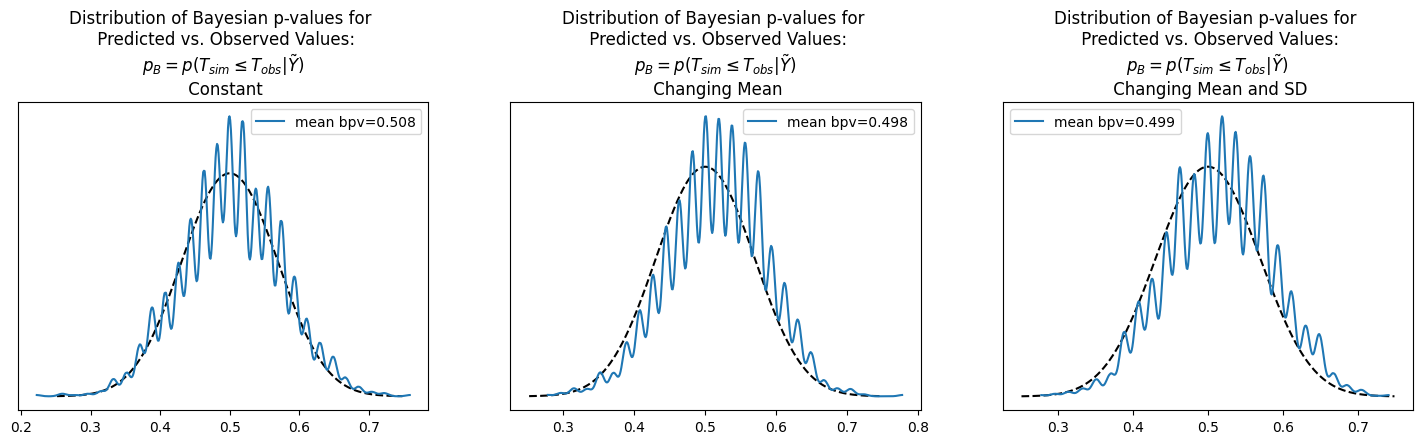

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
az.plot_bpv(idata_const, kind="p_value", ax=ax[0])
ax[0].set_title("Distribution of Bayesian p-values for \n Predicted vs. Observed Values:\n"+r"$p_{B} = p(T_{sim}\leq T_{obs}| \tilde{Y})$" + "\n Constant")
#compute the bpv for each draw across all observations
ax[0].legend([f"mean bpv={np.float((lastfrost['DAY'].mean() > idata_const['posterior_predictive']['Y_obs'].mean(axis=2)).mean()):.3f}"])
az.plot_bpv(idata_changing_mean, kind="p_value", ax=ax[1])
ax[1].set_title("Distribution of Bayesian p-values for \n Predicted vs. Observed Values:\n"+r"$p_{B} = p(T_{sim}\leq T_{obs}| \tilde{Y})$" +" \n Changing Mean")
ax[1].legend([f"mean bpv={np.float((lastfrost['DAY'].mean() > idata_changing_mean['posterior_predictive']['Y_obs'].mean(axis=2)).mean()):.3f}"])
az.plot_bpv(idata_changing_mean_sd, kind="p_value", ax=ax[2])
ax[2].set_title("Distribution of Bayesian p-values for \n Predicted vs. Observed Values:\n"+r"$p_{B} = p(T_{sim}\leq T_{obs}| \tilde{Y})$" +" \n Changing Mean and SD")
ax[2].legend([f"mean bpv={np.float((lastfrost['DAY'].mean() > idata_changing_mean_sd['posterior_predictive']['Y_obs'].mean(axis=2)).mean()):.3f}"])




We can also view the bpv computer per observation.  For each observation, the bpv should be about 0.5, resulting in a uniform distribution at the white line and the variation in the uniform distribution shown by the shaded gray area.  In all three models, the simulated results for each observation are within what is expected, though the models with varying means have more variation within the gray band. When the overall bpv is computed by averaging over the bpv of each observation, again the bpv is close to 0.5 for all models.

Text(0.5, 1.0, 'Bayesian p-values per Observation:\n Changing Mean and SD')

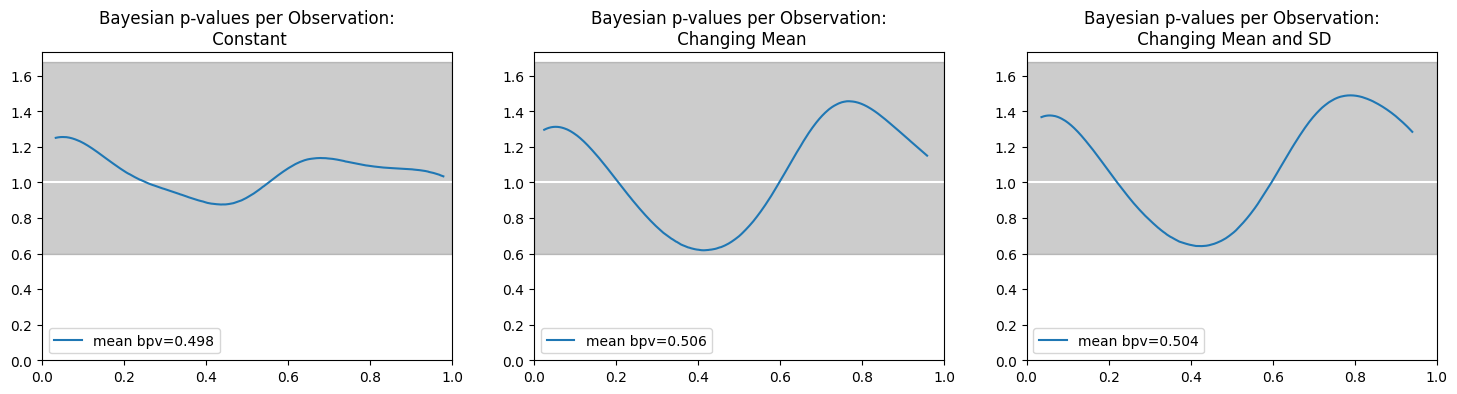

In [610]:
fig, ay = plt.subplots(1, 3, figsize=(18,4))
az.plot_bpv(idata_const, ax=ay[0])
#compute the bpv for each observation across all draws
bpv_per_obs_const = np.array([(lastfrost['DAY'] > idata_const['posterior_predictive']['Y_obs'][0][i]).mean() for i in range(0,4000)])
ay[0].legend([f"mean bpv={np.float(bpv_per_obs_const.mean()):.3f}"])
ay[0].set_title("Bayesian p-values per Observation:"+ "\n Constant")
az.plot_bpv(idata_changing_mean, ax=ay[1])
bpv_per_obs_changing_mean = np.array([(lastfrost['DAY'] > idata_changing_mean['posterior_predictive']['Y_obs'][0][i]).mean() for i in range(0,4000)])
ay[1].legend([f"mean bpv={np.float(bpv_per_obs_changing_mean.mean()):.3f}"])
ay[1].set_title("Bayesian p-values per Observation:"+ "\n Changing Mean")
az.plot_bpv(idata_changing_mean_sd, ax=ay[2])
bpv_per_obs_changing_mean_sd = np.array([(lastfrost['DAY'] > idata_changing_mean_sd['posterior_predictive']['Y_obs'][0][i]).mean() for i in range(0,4000)])
ay[2].legend([f"mean bpv={np.float(bpv_per_obs_changing_mean_sd.mean()):.3f}"])
ay[2].set_title("Bayesian p-values per Observation:"+ "\n Changing Mean and SD")

Finally, bpv can be computed to evaluate any statistic.  In this case, the solid line represents the distribution of the predicted mean values and the dot is the observed mean.  As the distribution shifts farther right compared to the dot, indicating more predicted values are greater than the observed values, the bpv decreases. The values for the means are close to 0.5 for all models, but the bpv for the standard deviation is a little lower for the models with changing mean and yet lower for changing mean and standard deviation.

Text(0.5, 1.0, 'Predicted Standard Deviations Compared to \n Observed Data: Model with Changing Mean and SD')

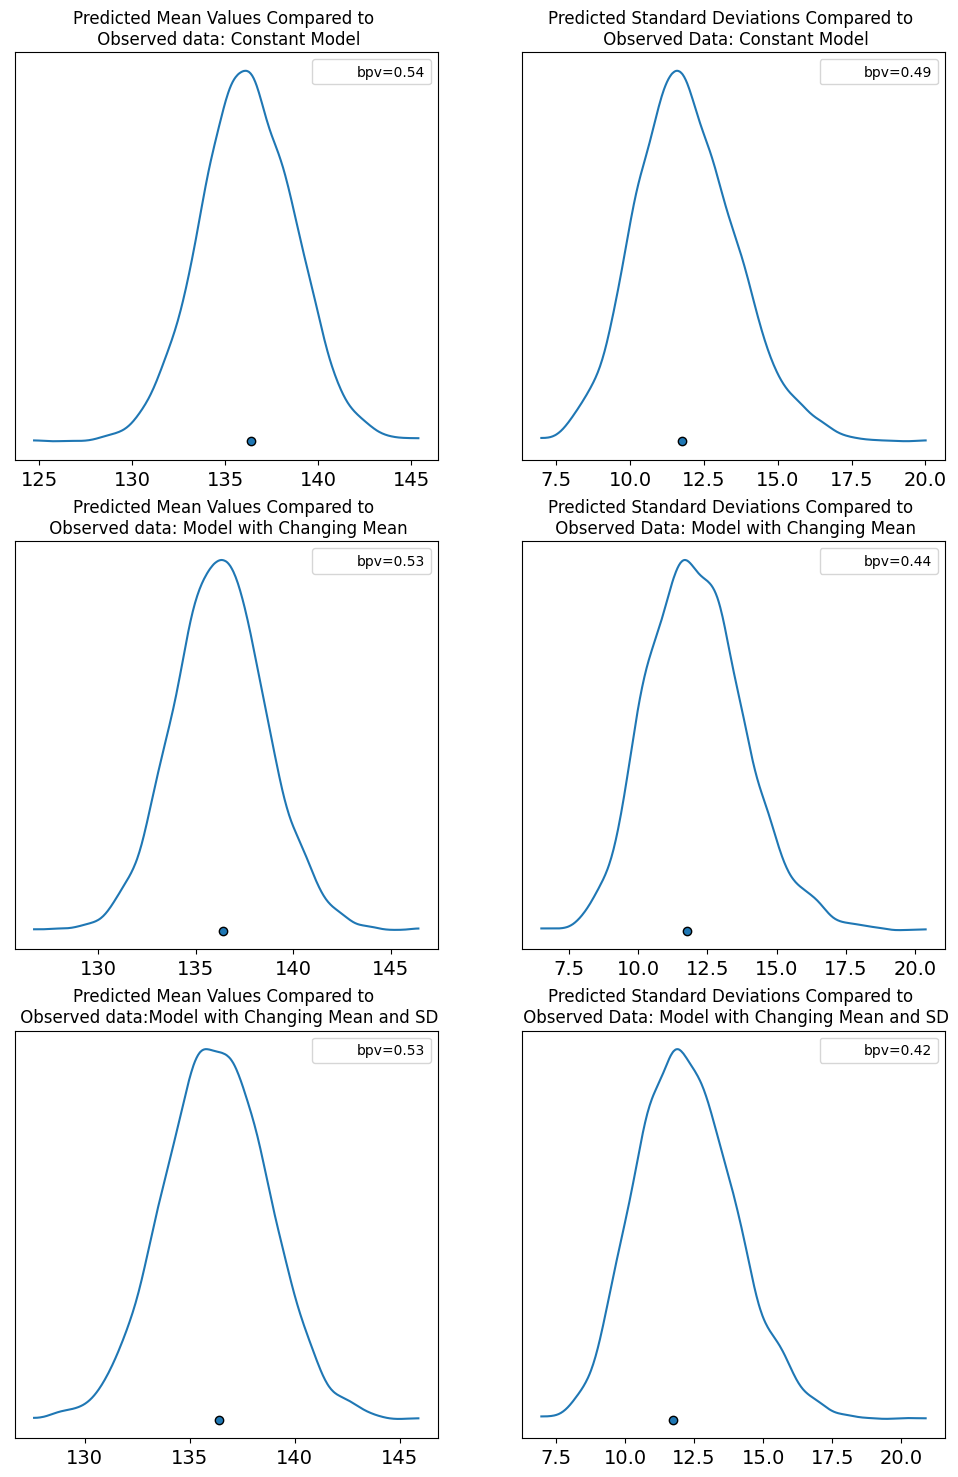

In [ ]:
# Consider the mean and standard deviation of the posterior predictive distribution compared to the observations
fig, ax = plt.subplots(3, 2, figsize=(12, 18))
az.plot_bpv(idata_const, kind="t_stat", t_stat="mean", ax=ax[0,0])
ax[0,0].set_title("Predicted Mean Values Compared to \n Observed data: Constant Model")
az.plot_bpv(idata_const, kind="t_stat", t_stat="std", ax=ax[0,1])
ax[0,1].set_title("Predicted Standard Deviations Compared to \n Observed Data: Constant Model")
az.plot_bpv(idata_changing_mean, kind="t_stat", t_stat="mean", ax=ax[1,0])
ax[1,0].set_title("Predicted Mean Values Compared to \n Observed data: Model with Changing Mean")
az.plot_bpv(idata_changing_mean, kind="t_stat", t_stat="std", ax=ax[1,1])
ax[1,1].set_title("Predicted Standard Deviations Compared to \n Observed Data: Model with Changing Mean")
az.plot_bpv(idata_changing_mean_sd, kind="t_stat", t_stat="mean", ax=ax[2,0])
ax[2,0].set_title("Predicted Mean Values Compared to \n Observed data: Model with Changing Mean and SD")
az.plot_bpv(idata_changing_mean_sd, kind="t_stat", t_stat="std", ax=ax[2,1])
ax[2,1].set_title("Predicted Standard Deviations Compared to \n Observed Data: Model with Changing Mean and SD")

When considering all the information about model computation statistics (such as degree of autocorrelation) and model validation statistics (such as loo and bpv), it seems that the model with the changing mean is the best choice. While the fit is improved by allowing the standard deviation to vary with time, the standard deviation distribution includes no change with time. Given the principle of parsimony in modeling, which recommends a simpler model unless added complexity gives a significant benefit, I prefer the model with only changing mean. The constant model is yet more parsimonious, but had a few flaws, including poorer leave-one-out predictions of observed data and an inability to account for an apparent change in time.